In [4]:
import torch
import torch.nn as nn
import torch.optim as optm
import os
import json
from metrics_amazon import CM, f1_score0, f1_score1, Recall, Precision, ACC
import numpy as np
from preprocess import load_tif_image, extract_temporal_sorted_patches, extract_sorted_patches, divide_pred_windows, preprocess_patches
import matplotlib.pyplot as plt

import imageio
import matplotlib.animation as animation
from IPython.display import HTML


In [2]:
experiment = 'custom_exp1'

preds = np.load(os.path.join('work_dirs', experiment, 'preds.npy'))
print(preds.shape)
# preds_reconstructed = np.load(os.path.join('work_dirs', experiment, 'img_reconstructed.npy'))
# def_preds_reconstructed = np.load(os.path.join('work_dirs', experiment, 'def_img_reconstructed.npy'))

mean_std = np.load(os.path.join('work_dirs', experiment, 'mean_std.npy'))

training_config = json.load(open(os.path.join('work_dirs', experiment, 'model_training.json')))
print(training_config)

(79248, 2, 2, 64, 64)
{'pre_seq_length': 4, 'aft_seq_length': 2, 'total_length': 6, 'batch_size': 16, 'val_batch_size': 16, 'epoch': 100, 'lr': 0.0001, 'metrics': ['mse', 'mae'], 'ex_name': 'custom_exp1', 'dataname': 'custom', 'in_shape': [4, 1, 64, 64], 'patience': 10, 'delta': 0.0001, 'amazon_mask': True, 'pixel_size': '1K', 'patch_size': 64, 'overlap': 0.15, 'loss': 'focal', 'aux_metrics': ['f1_score0', 'f1_score1', 'CM'], 'normalize': True}


In [3]:
# Load Test Image
deter_img = load_tif_image('data/DETER/deter_increments_1km_1week.tif')

mask = load_tif_image('data/IBAMA_INPE/1K/tiff_filled/mask.tif')
mask = mask[:deter_img.shape[1], :deter_img.shape[2]]

deter_img[:, mask == 0] = -1
deter_img[deter_img > 0] = 1

deter_img_train = deter_img[:96]
# 2022 = 1 * 48 = 48
# deter_img_val = deter_img[96:(96 + 48)]
# # 2023 = 1 * 48 = 48
# deter_img_test = deter_img[(96 + 48):(96 + 48 + 48)]
del deter_img

In [5]:
print(deter_img_train.shape, mask.shape)

(96, 2333, 3005) (2333, 3005)


In [2]:
def display_video(video):
    fig = plt.figure()
    ims = []
    for i in range(video.shape[0]):
        im = plt.imshow(video[i], animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    plt.close()
    # return HTML(ani.to_jshtml())
    return HTML(ani.to_html5_video())

In [3]:
html_video = display_video(deter_img_train)

NameError: name 'deter_img_train' is not defined

In [6]:
patch_size=64
overlap=0
min_def = 0.0005
window_size = 6

train_patches = preprocess_patches(deter_img_train, patch_size=patch_size, overlap=overlap)
print('Train Patches:', train_patches.shape)
del deter_img_train

mask_train_patches = preprocess_patches(mask, patch_size=patch_size, overlap=overlap)
print('Mask Train Patches:', mask_train_patches.shape)

data_files, mask_files, _ = divide_pred_windows(train_patches, min_def=min_def, window_size=window_size,\
    mask_patches=mask_train_patches)
print(f'Training shape: {data_files.shape} - {mask_files.shape}')

Extracting patches...
(96, 2333, 3005)
Train Patches: (1656, 96, 64, 64)
Extracting patches...
(2333, 3005)
Mask Train Patches: (1656, 64, 64)


Dividing in prediction windows:   0%|          | 0/150696 [00:00<?, ?it/s]/home/thiago/python-envs/base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thiago/python-envs/base/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Dividing in prediction windows: 100%|██████████| 150696/150696 [00:12<00:00, 11842.06it/s]


138129 Skipped Images
Training shape: (12567, 6, 64, 64) - (12567, 64, 64)


In [8]:
skip_count = 0
def_indexes = []
def_means = []
for i in range(data_files.shape[0]):
    # print(f'Processing {i} of {test_files.shape[0]}')
    # test_files[i] = (test_files[i] - mean_std[0])/mean_std[1]
    patches = data_files[i]
    labels = patches[-2:]
    _label = labels[:, mask_files[i] == 1]
    _label[_label > 0] = 1
    mean = np.mean(_label, axis=(1))
    # 1/0
    # Deal with Nan
    # if np.isnan(mean[0]): mean[0] = 0
    # if np.isnan(mean[1]): mean[1] = 0
    # if mean[0] < min_def or mean[1] < min_def:
    if mean[0] + mean[1] < min_def:
        skip_count += 1
        # print('here')
        continue
    # print(mean.shape)
    # print(mean[0] + mean[1])
    def_indexes.append(i)
    def_means.append(mean[0] + mean[1])
    # patches_pred = preds[i, 1]
    # patches_pred[:, mask_test_files[i] == 0] = -1
    # patches[:, mask_test_files[i] == 0] = -1
    # print('finished')
    # break
print(f'Skipped {skip_count} patches')

Skipped 0 patches


In [ ]:
# sort def_indexes by def_means
def_indexes = np.array(def_indexes)
def_means = np.array(def_means)
def_indexes = def_indexes[np.argsort(def_means)]
print(def_indexes)
print(def_means[np.argsort(def_means)])
cont = 0

10670
10670
(6, 64, 64)
0.009033203125 [0.00756836 0.00146484]


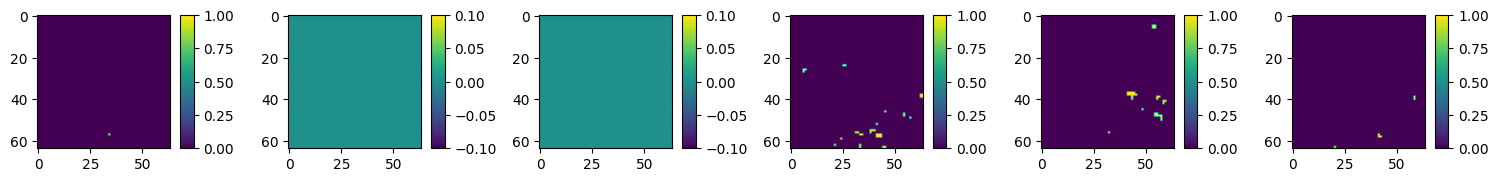

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Pick a random number from the list
# Create an array of integeer indexes
indexes = np.arange(data_files.shape[0])
index = np.random.choice(indexes)
print(index)
# cont -= -1
# index = def_indexes[cont]

print(index)
patches = data_files[index]
print(patches.shape)

labels = patches[-2:]
_label = labels[:, mask_files[i] == 1]
_label[_label > 0] = 1
mean = np.mean(_label, axis=(1))
print(np.sum(mean), mean)
    
# patches_pred[:, mask_test_files[index] == 0] = -1
# patches[:, mask_test_files[index] == 0] = -1

# patches[patches > 0] = 1
# patches[patches < 0] = 0
    
fig, axs = plt.subplots(1, 6, figsize=(15, 10))

# patches_plot = np.concatenate((patches, patches_pred), axis=0)

for j in range(6):
    im = axs[j].imshow(patches[j])
    divider = make_axes_locatable(axs[j])
    cax = divider.append_axes("right", size="10%", pad=0.1)
    fig.colorbar(im, cax=cax)
    # axs[i, j].axis('off')

plt.tight_layout()
plt.show()